In [1]:
!pip install -U segmentation-models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 1.6 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import tifffile as tiff
from tqdm.auto import tqdm
from glob import glob
import gc
import os
import warnings 
import random
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
gc.enable()
warnings.simplefilter('ignore')

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy
import albumentations as A
from sklearn.model_selection import train_test_split
import segmentation_models as sm
from segmentation_models import Unet
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, Concatenate, Activation, Add, multiply, add, concatenate, LeakyReLU, ZeroPadding2D, UpSampling2D, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import backend as K 

sm.set_framework('tf.keras')
sm.framework()

Segmentation Models: using `keras` framework.


'tf.keras'

In [3]:
cfg = {
    'train_df': '../input/hubmap-organ-segmentation/train.csv',
    'train_img': '../input/new-hubmap-dataset-256p/images/',
    'train_masks': '../input/new-hubmap-dataset-256p/masks/',
    'batch size': 8,
    'epochs': 50,
    'img_shape': 256,
    'lr': 1e-03
}

In [4]:
class DataSetGen(tf.keras.utils.Sequence):
    def __init__(
        self,
        images: list,
        img_dir=cfg['train_img'], 
        mask_dir=cfg['train_masks'],
        img_shape=cfg['img_shape'],
        batch_size=cfg['batch size'],
        augments= True,
        shuffle=True
    ):
        self.images = images
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.img_shape = img_shape
        self.batch_size = batch_size
        self.augments = augments
        self.shuffle = shuffle
        self.on_epoch_end()
        if augments:
            self.transform = A.Compose([
                A.augmentations.crops.RandomResizedCrop(height=self.img_shape, width=self.img_shape),
                A.augmentations.Rotate(limit=90, p=0.5),
                A.augmentations.HorizontalFlip(p=0.5),
                A.augmentations.VerticalFlip(p=0.5),
                A.augmentations.transforms.ColorJitter(p=0.5),
                A.OneOf([
                    A.OpticalDistortion(p=0.5),
                    A.GridDistortion(p=.5),
                    A.PiecewiseAffine(p=0.5),
                ], p=0.5),
                A.OneOf([
                    A.HueSaturationValue(10, 15, 10),
                    A.CLAHE(clip_limit=4),
                    A.RandomBrightnessContrast(),            
                ], p=0.5)
            ])
        
    def on_epoch_end(self):
        '''
        Called after the end of every epoch, here it shuffles the dataframe
        '''
        if self.shuffle:
            random.shuffle(self.images)
        return self.images
    
    
    def __len__(self):
        '''
        Denotes the number of batches per epoch
        '''
        return len(self.images) // self.batch_size
    
    
    def __getitem__(self, idx):
        '''
        Generates one batch of data
        '''
        X=[]; y=[]
        batch = self.images[idx * self.batch_size: (idx + 1) * self.batch_size]
        for img_id in batch:
            img = cv2.imread(os.path.join(self.img_dir, img_id), cv2.COLOR_BGR2RGB)
            #img = cv2.resize(img, (cfg['img_shape'], cfg['img_shape']))
            mask = cv2.imread(os.path.join(self.mask_dir, img_id), cv2.COLOR_BGR2GRAY)
            #mask = cv2.resize(mask, (cfg['img_shape'], cfg['img_shape'])).reshape((cfg['img_shape'], cfg['img_shape'], 1))
            if self.augments:
                aug = self.transform(image=img, mask=mask)
                img = aug['image'] / 255.0; mask = aug['mask']
            else:
                img = img / 255.0
            X.append(img); y.append(mask)
        return np.array(X).astype(np.float32), np.array(y).astype(np.float32)

In [5]:
try:
    train_imgs, valid_imgs = train_test_split(imgs, test_size=0.2, random_state=42, shuffle=False)
    del imgs; gc.collect()
except:
    imgs = os.listdir(cfg['train_img'])#[:2808]
    train_imgs, valid_imgs = train_test_split(imgs, test_size=0.2, random_state=42, shuffle=False)
    del imgs; gc.collect()

In [6]:
train_ds = DataSetGen(train_imgs, augments=True)
valid_ds = DataSetGen(valid_imgs, augments=False)

In [7]:
# def dice_coef(y_true, y_pred, smooth=1):
#     y_true_f = K.flatten(y_true)
#     y_pred_f = K.flatten(y_pred)
#     intersection = K.sum(y_true_f * y_pred_f)
#     return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# def iou_coef(y_true, y_pred, smooth=1e-06):
#     intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
#     union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
#     iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
#     return iou


# def dice_loss(y_true, y_pred):
#     smooth = 1.
#     y_true = tf.cast(y_true, tf.float32)
#     y_true_f = K.flatten(y_true)
#     y_pred_f = K.flatten(y_pred)
#     intersection = y_true_f * y_pred_f
#     score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
#     return 1. - score

# def bce_dice_loss(y_true, y_pred):
#     return binary_crossentropy(tf.cast(y_true, tf.float32), y_pred) + 0.5 * dice_loss(tf.cast(y_true, tf.float32), y_pred)

# def weighted_loss(y_true, y_pred):
#     # Calculate the base loss
#     ce = K.sparse_categorical_crossentropy(y_true, y_pred)
#     # Apply the weights
#     one_weight = 1.0
#     zero_weight = 1e-2
#     weight_vector = y_true * one_weight + (1. - y_true) * zero_weight
#     weight_vector = K.squeeze(weight_vector, axis=-1)
#     weighted_ce = weight_vector * ce

#     # Return the mean error
#     return K.mean(weighted_ce)

# def soft_dice_loss(y_true, y_pred, epsilon=1e-6):
#     #ref: https://www.jeremyjordan.me/semantic-segmentation/
#     y_true = tf.cast(y_true, tf.float32)
#     axes = tuple(range(1, len(y_pred.shape)-1)) 
#     numerator = 2. * np.sum(y_pred * y_true, axes)
#     denominator = np.sum(np.square(y_pred) + np.square(y_true), axes)
#     return 1 - np.mean((numerator + epsilon) / (denominator + epsilon))

In [8]:
# base = sm.Linknet(
#     backbone_name='efficientnetb2',
#     input_shape=(None, None, 3),
#     classes=1,
#     activation='sigmoid',
#     weights=None,
#     encoder_weights='imagenet',
#     encoder_freeze=False,
#     encoder_features='default',
#     decoder_block_type='upsampling',
#     decoder_filters=(256, 128, 64, 32, 16),
#     decoder_use_batchnorm=True
# )

# base = sm.Unet(
#     backbone_name= 'efficientnetb7',
#     input_shape= (None, None, 3), #the H and W of the image should be divisible by 32
#     classes= 1,
#     activation= 'sigmoid',
#     weights= None, 
#     encoder_weights= 'imagenet',
#     encoder_freeze= False,
#     encoder_features= 'default',
#     decoder_block_type= 'upsampling',
#     decoder_filters= (256, 128, 64, 32, 16),
#     decoder_use_batchnorm= True
# )

base = sm.FPN(
    backbone_name='efficientnetb6',
    input_shape=(None, None, 3),
    classes=1,
    activation='sigmoid',
    weights=None,
    encoder_weights='imagenet',
    encoder_freeze=False,
    encoder_features='default',
    pyramid_block_filters=256,
    pyramid_use_batchnorm=True,
    pyramid_aggregation='concat',
    pyramid_dropout=None
)

inpt = tf.keras.Input(shape=(cfg['img_shape'], cfg['img_shape'], 3))
out = base(inpt)
model = tf.keras.Model(inputs=inpt, outputs=out)
model.summary()

165535744/165527152 [==============================] - 9s 0us/step
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
model (Functional)           (None, None, None, 1)     44444681  
Total params: 44,444,681
Trainable params: 44,217,945
Non-trainable params: 226,736
_________________________________________________________________


In [9]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss= sm.losses.bce_jaccard_loss, 
    metrics= [sm.metrics.iou_score, sm.metrics.f1_score]
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='/kaggle/working/best_model.h5',
    monitor='val_loss',
    verbose=0,
    save_best_only=True,
    mode='min'
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.9,
    patience=2,
    verbose=0,
    min_lr=1e-07,
    mode='min'
)

es = tf.keras.callbacks.EarlyStopping(
    patience=5,
    min_delta=0,
    monitor='val_loss',
    restore_best_weights=True,
    verbose=0,
    mode='min',
    baseline=None
)

LR_START = cfg['lr']
LR_MAX = 1e-2
LR_RAMPUP_EPOCHS = 2
LR_SUSTAIN_EPOCHS = 0
LR_STEP_DECAY = 0.316
LR_STEP_EPOCHS = 5

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = LR_MAX * LR_STEP_DECAY**((epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS)// LR_STEP_EPOCHS)
    return lr

lr = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)

history = model.fit(train_ds, 
                    validation_data=valid_ds,
                    epochs = cfg['epochs'],
                    callbacks=[es, checkpoint, reduce_lr],
                    use_multiprocessing=True,
                    workers=4,
                    verbose=1
                   )

Epoch 1/50
561/561 [==============================] - 361s 579ms/step - loss: 1.0281 - iou_score: 0.2509 - f1-score: 0.3782 - val_loss: 1.0103 - val_iou_score: 0.2663 - val_f1-score: 0.4058
Epoch 2/50
561/561 [==============================] - 323s 574ms/step - loss: 0.9145 - iou_score: 0.3353 - f1-score: 0.4740 - val_loss: 0.7153 - val_iou_score: 0.4586 - val_f1-score: 0.6002
Epoch 3/50
561/561 [==============================] - 329s 581ms/step - loss: 0.8596 - iou_score: 0.3707 - f1-score: 0.5085 - val_loss: 0.8080 - val_iou_score: 0.3969 - val_f1-score: 0.5377
Epoch 4/50
561/561 [==============================] - 329s 580ms/step - loss: 0.7809 - iou_score: 0.4220 - f1-score: 0.5596 - val_loss: 0.7778 - val_iou_score: 0.4788 - val_f1-score: 0.6094
Epoch 5/50
561/561 [==============================] - 326s 578ms/step - loss: 0.7556 - iou_score: 0.4408 - f1-score: 0.5748 - val_loss: 0.7182 - val_iou_score: 0.4698 - val_f1-score: 0.6112
Epoch 6/50
561/561 [==============================

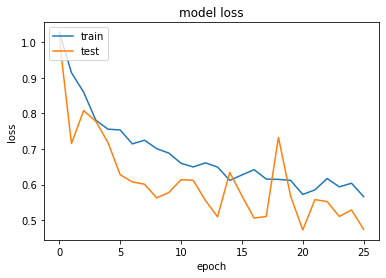

In [10]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

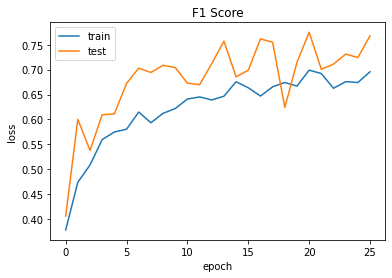

In [11]:
plt.plot(history.history['f1-score'])
plt.plot(history.history['val_f1-score'])
plt.title('F1 Score')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

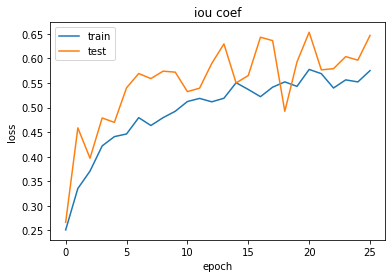

In [12]:
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('iou coef')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

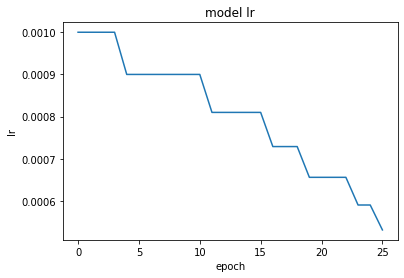

In [13]:
plt.plot(history.history['lr'])
plt.title('model lr')
plt.ylabel('lr')
plt.xlabel('epoch')
plt.show()